In [7]:
# Notebook header: reproducibility & imports
RANDOM_SEED = 42

import os, random
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

# reproducible seeds
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# scikit-learn helpers
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, roc_curve, auc,
                             average_precision_score, classification_report)

# plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.dpi'] = 120

# Create output directories if they don't exist
# Note the '../' to go up one level from the 'notebooks' directory
os.makedirs('../tables', exist_ok=True)
os.makedirs('../figures', exist_ok=True)


# Exploratory Data Analysis (EDA) - HR Attrition

**Objective:** To perform an initial analysis of the IBM HR Attrition dataset.

- **Dataset Source:** `data/raw/WA_Fn-UseC_-HR-Employee-Attrition.csv`
- **Goal:** Understand the dataset's structure, identify data quality issues (missing values, outliers), analyze feature distributions, and examine initial relationships with the target variable, 'Attrition'.

In [8]:
df = pd.read_csv('../data/raw/WA_Fn-UseC_-HR-Employee-Attrition.csv')
print(f"Dataset Shape: {df.shape}")

Dataset Shape: (1470, 35)


In [9]:
summary = pd.DataFrame({
    'n_rows': [df.shape[0]],
    'n_cols': [df.shape[1]],
    'missing_cells': [df.isna().sum().sum()],
    'missing_cols': [df.isna().sum().gt(0).sum()],
})

# Save the summary table
summary.to_csv('../tables/dataset_summary.csv', index=False)
summary

,n_rows,n_cols,missing_cells,missing_cols
0,1470,35,0,0


In [10]:
target_col = 'Attrition'
class_counts = df[target_col].value_counts()
class_counts.to_frame('count').to_csv('../tables/attrition_counts.csv')

attrition_rate = class_counts.get('Yes', 0) / (class_counts.sum())
print(class_counts)
print(f'\nAttrition rate: {attrition_rate:.2%}')

Attrition
No     1233
Yes     237
Name: count, dtype: int64

Attrition rate: 16.12%


In [11]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
desc_stats = df[num_cols].agg(['count', 'mean', 'median', 'std', 'min', 'max']).T

desc_stats.to_csv('../tables/descriptive_stats_numeric.csv')
desc_stats.head()

,count,mean,median,std,min,max
Age,1470.0,36.923810,36.0,9.135373,18.0,60.0
DailyRate,1470.0,802.485714,802.0,403.509100,102.0,1499.0
DistanceFromHome,1470.0,9.192517,7.0,8.106864,1.0,29.0
Education,1470.0,2.912925,3.0,1.024165,1.0,5.0
EmployeeCount,1470.0,1.000000,1.0,0.000000,1.0,1.0


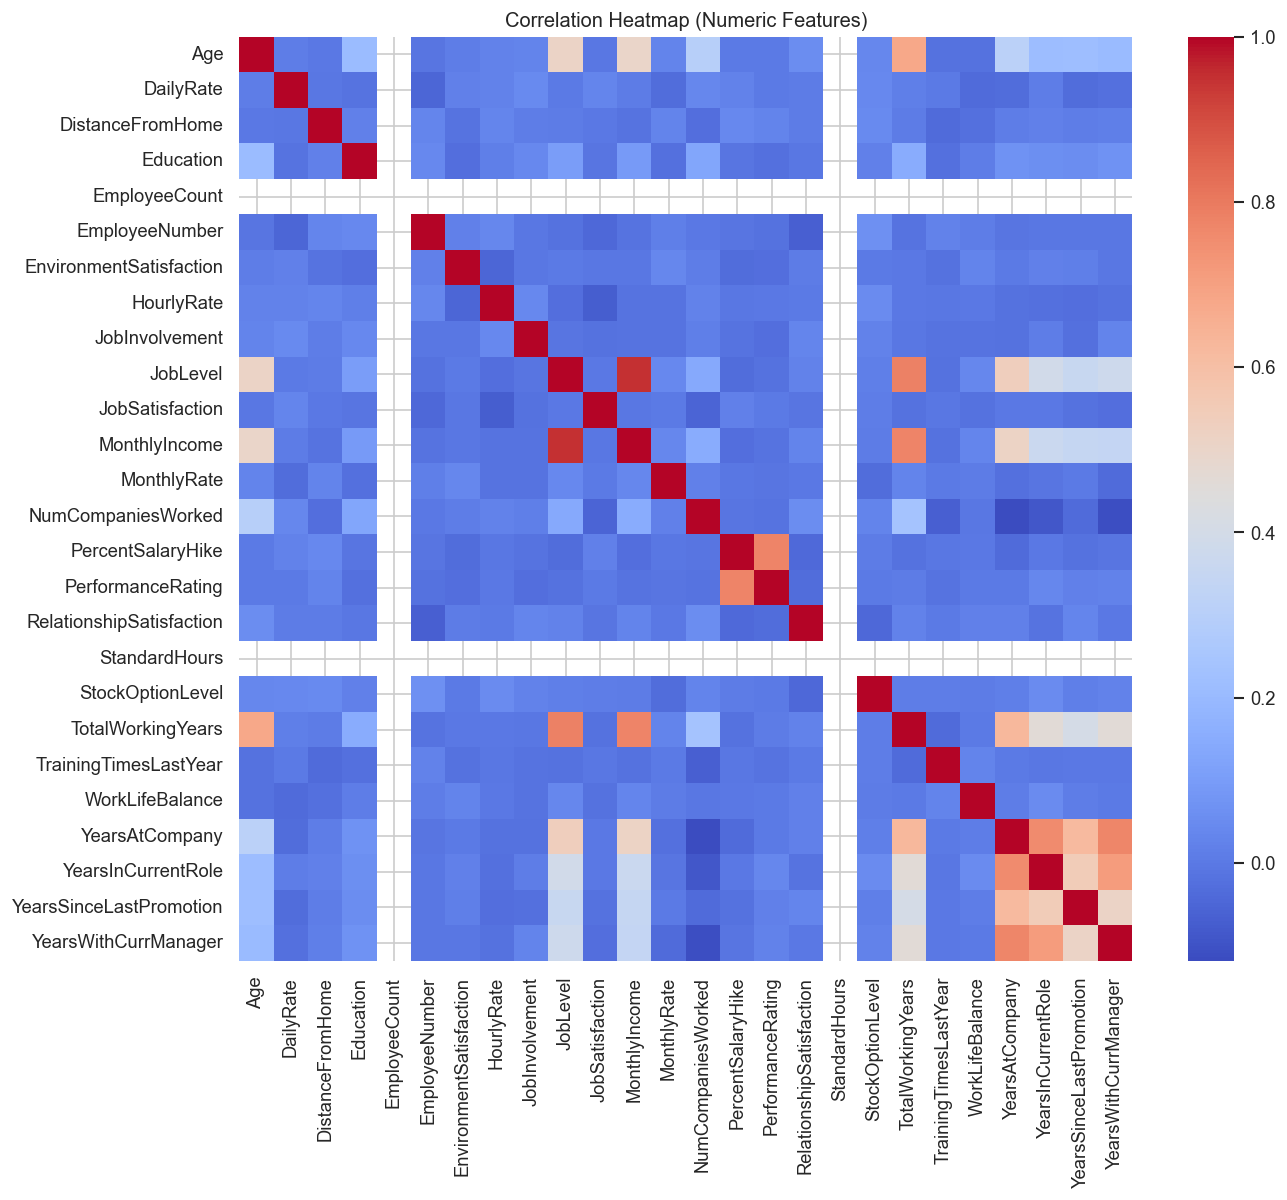

In [12]:
corr = df[num_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap (Numeric Features)')
plt.savefig('../figures/eda_corr_heatmap.png', bbox_inches='tight', dpi=300)
plt.show()

corr.to_csv('../tables/correlation_numeric.csv')

In [13]:
os.makedirs('../figures/eda_distributions', exist_ok=True)
for col in num_cols:
    # Histogram
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col].dropna(), kde=False, bins=30)
    plt.title(f'Histogram: {col}')
    plt.savefig(f'../figures/eda_distributions/hist_{col}.png', bbox_inches='tight', dpi=300)
    plt.close()
    
    # Boxplot
    plt.figure(figsize=(8, 2))
    sns.boxplot(x=df[col].dropna())
    plt.title(f'Boxplot: {col}')
    plt.savefig(f'../figures/eda_distributions/box_{col}.png', bbox_inches='tight', dpi=300)
    plt.close()


In [14]:
os.makedirs('../figures/bivariate_plots', exist_ok=True)
for col in num_cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=target_col, y=col, data=df)
    plt.title(f'{col} by {target_col}')
    plt.savefig(f'../figures/bivariate_plots/box_{col}_by_attrition.png', bbox_inches='tight', dpi=300)
    plt.close()

In [15]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols.remove(target_col)

for col in cat_cols:
    ct = pd.crosstab(df[col], df[target_col], normalize='index')
    ct.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title(f'Proportion of Attrition by {col}')
    plt.ylabel('Proportion')
    plt.tight_layout()
    plt.savefig(f'../figures/bivariate_plots/bar_{col}_by_attrition.png', dpi=300)
    plt.close()

# EDA Summary

- **Class Imbalance:** The dataset is imbalanced, with an attrition rate of approximately 16.12%. This will require techniques like stratified sampling and potentially resampling (SMOTE) or class weights.
- **Data Quality:** There are no missing values in the dataset.
- **Correlations:** Several features are highly correlated (e.g., `JobLevel` and `MonthlyIncome`). `PerformanceRating` has very low variance.
- **Key Predictors (Initial Look):** Variables like `OverTime`, `MonthlyIncome`, `JobLevel`, and `Age` show visible differences between the 'Yes' and 'No' attrition groups.